In [1]:
%matplotlib inline

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from matplotlib import style
from pandas_datareader import data
import random
from SALib.sample import latin
from functions.stylizedfacts import *
import scipy.stats as stats
from functions.evolutionaryalgo import *
from pandas_datareader import data
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
import numpy as np
from functions.sensitivity_analysis import *
import json
from SALib.sample import latin, saltelli, fast_sampler
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris

In [2]:
style.use('seaborn-ticks')

# Fundamentals decoupled in an agent-based model: exploring trend-following and mean-reversion chartism

By **Joeri Schasfoort**

This is the notebook which belongs to the paper of the same name. That paper contributes to the debate about market efficiency by presenting a behavioural agent-based model which suggests that market prices might be decoupled from fundamentals for longer periods than previously thought. This decoupling is explained by an increased prevalence of technical or chartist trading. In the chartist and fundamentalist model framework, the model distinguishes between trend-following and a mean-reversion chartist trading. Replacing fundamentalist trading with the latter causes stock-market prices to become decoupled from their fundamental value. Because, just like fundamentalist trading, mean-reversion trading prevents excessive long-term price predictability as a consequence of trend-following, an increase of meanreversion trading at the expense of fundamentalist trading does not diminish the models ability to reproduce the stylized facts of stock market returns: no autocorrelation, volatility clustering, long memory, and fat tails.

The notebook allows for the replication of the main results and graphs of the paper. The results the notebook generals will differ slightly from those in the paper as those where computed using a larger amount of simulations on a cluster computer. 

The notebook is similar but not identical in structure to the paper. First, it present the model logic in Python code. Then, it shows how to download the data and calculate the stylized facts. After that, Morris methods are used to determine the sensitivity to input parameters. The notebook then shows how to estimate the model, simulate its estimated baseline dynamics, compare its performance to a model version without mean-reversion, and perform experiments switching between fundamentalist and mean-reversion trading. 

## The model

In [3]:
def sim_fin_model(traders, orderbook, parameters, seed=1):
    """
    The main model function
    :param traders: list of Agent objects
    :param orderbook: object Order book
    :param parameters: dictionary of parameters
    :param seed: integer seed to initialise the random number generators
    :return: list of simulated Agent objects, object simulated Order book
    """
    random.seed(seed)
    np.random.seed(seed)
    fundamental = [parameters["fundamental_value"]]

    for tick in range(parameters['horizon_max'] + 1, parameters["ticks"]):
        # evolve the fundamental value via random walk process
        fundamental.append(fundamental[-1] + parameters["std_fundamental"] * np.random.randn())

        # select random sample of active traders
        active_traders = random.sample(traders, int((parameters['trader_sample_size'])))

        # update common expectation components
        mid_price = orderbook.tick_close_price[-1]
        fundamental_component = np.log(fundamental[-1] / mid_price)
        chartist_component = np.cumsum(orderbook.returns[-parameters['horizon_max']:]
                                       ) / np.arange(1., float(parameters['horizon_max'] + 1))

        for trader in active_traders:
            # update trader specific expectations
            noise_component = parameters['std_noise'] * np.random.randn()

            fcast_return = trader.var.forecast_adjust * (
                trader.var.weight_fundamentalist * fundamental_component +
                trader.var.weight_chartist * chartist_component[trader.par.horizon] +
                trader.var.weight_random * noise_component -
                trader.var.weight_mean_reversion * chartist_component[trader.par.horizon])

            fcast_price = mid_price * np.exp(fcast_return)

            # submit orders
            if fcast_price > mid_price:
                bid_price = fcast_price * (1. - trader.par.spread)
                orderbook.add_bid(bid_price, abs(int(np.random.normal(scale=parameters['std_vol']))), trader)
            elif fcast_price < mid_price:
                ask_price = fcast_price * (1 + trader.par.spread)
                orderbook.add_ask(ask_price, abs(int(np.random.normal(scale=parameters['std_vol']))), trader)

        # match orders in the order-book
        while True:
            matched_orders = orderbook.match_orders()
            if matched_orders is None:
                break

        # clear and update order-book history
        orderbook.cleanse_book()
        orderbook.fundamental = fundamental

    return traders, orderbook

## The data

I collect data from three sources. First, I collect daily data on nominal prices from the S&P500 starting on the 1st of August 2008 and ending on the 16th August 2018 (2509 observations) from the Federal Reserve of St. Louis database. Second, I collect historical data on monthly S&P 500 prices and dividends from Robert Shiller’s database2 (Shiller, 2000). Third, I extract historical data on annual shortterm interest rates from the macro history database3 (Jordà et al., 2017). Table 1 presents the descriptive statistics of this data.

In [4]:
start_date = '2008-01-01'
end_date = '2018-08-16'

spy_nom_price = data.DataReader("SP500", 
                       start=start_date, 
                       end=end_date, 
                       data_source='fred')["SP500"].dropna()
spy_nom_returns = spy_nom_price.pct_change()[1:]

shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
schul_data = pd.read_excel('http://www.macrohistory.net/JST/JSTmoneyR3.xlsx', sheetname='Data')[['year', 'country', 'stir']]
schul_data = schul_data.loc[(schul_data.country == 'USA')]
schul_data = schul_data.iloc[1:]
schul_data = schul_data.set_index('year')

C:\Users\joerischasfoort\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


**Table 1:** Descriptive statistics data, price and dividend data was rounded off at one decimal point and T-bill rates at at four decimal points.

In [5]:
table1_descriptives = pd.DataFrame()
table1_descriptives['returns'] = spy_nom_returns.describe()
table1_descriptives['spy_real'] = shiller_data['Price'].describe()
table1_descriptives['Dividend'] = shiller_data['Dividend'].describe()
table1_descriptives['T-bill'] = schul_data['stir'].describe()
table1_descriptives = table1_descriptives.round(decimals=2)
table1_descriptives.to_csv('table1.csv', sep='&')
table1_descriptives

,returns,spy_real,Dividend,T-bill
count,2480.00,1771.00,1770.00,146.00
mean,0.00,516.59,15.35,4.09
std,0.01,556.28,8.67,2.93
min,-0.09,68.22,5.03,0.09
25%,0.00,171.56,8.61,1.89
50%,0.00,255.37,12.83,3.51
75%,0.01,619.11,19.51,5.42
max,0.12,2836.53,51.00,16.39


### The fundamental value

To be able to calculate the fundamental value, I extend the annual historical interest data to monthly data. 

In [6]:
schul_data['stir']

short_term_int = []
counter = -1
for idx in range(len(shiller_data)):
    if idx % 12 == 0:
        counter += 1
    try:
        short_term_int.append(schul_data['stir'].iloc[counter])
    except:
        pass

So that, I can calculate the discount rate $i_t + r$ for the NPV model. Where $i_t$ is the short-term interest rate time $t$ while $r$ represents the equity price premium which is assumed to be constant at 5.2 which is the level of the equity risk premium estimated by [Avdis & Wachter (2017)](https://doi.org/10.1016/j.jfineco.2017.06.003).

In [7]:
discount_rates = np.array(short_term_int) + 5.2
discount_rates = pd.Series(discount_rates).apply(div_by_hundred)

This allows me to calculate the fundamental value. I combine the Shiller and macro history datasets to calculate the fundamental value using the fixed equity premium net present value model. It states that the fundamental value is the sum of discounted future dividend rates

\begin{equation}
F_{t} = \sum_{t=1}^{\kappa} \frac{D_t}{(1 + i_t + r)^{t+1}},
\end{equation}

where $D_t$ is the dividend. I set the horizon over which to discount future dividends $\kappa$ to the point at which $\frac{D_t}{(1 + i_t + e)^t} < 0.01$. Using this equation, I calculate the ex-post fundamental value of the S\&P 500 in which I assume the annual interest rate holds for all months in that particular year.

In [8]:
fundamental_values = []
for idx, cf in enumerate(shiller_data['Dividend'][:-18]):
    next_period_divs = shiller_data['Dividend'][idx+1:]
    next_period_ints = discount_rates[idx+1]
    npv = calculate_npv(next_period_divs, next_period_ints)
    if not np.isnan(npv):
        fundamental_values.append(npv)
    else:
        break

In [9]:
# real_prices = shiller_data['Price'][:len(fundamental_values)]

This leads to the following plot found in the introduction of the paper: 

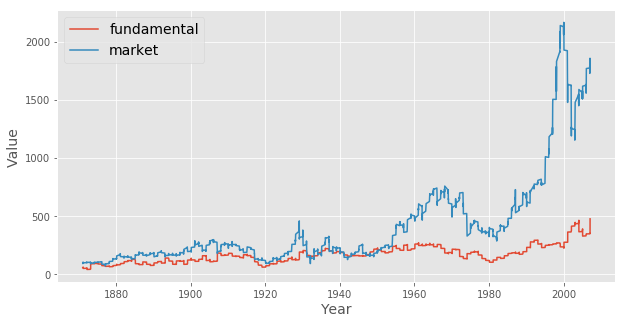

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

time=0

ax1.plot(shiller_data['Date'][time:len(fundamental_values)], fundamental_values[time:], label='fundamental')
ax1.plot(shiller_data['Date'][time:len(fundamental_values)], shiller_data['Price'][time:len(fundamental_values)], label='market')

ax1.set_ylabel('Value', fontsize='14')
ax1.set_xlabel('Year', fontsize='14')

ax1.legend(fontsize='14', loc='best')
fig.savefig('shiller_campbell_sp500.png')

### Bootstrapped data 
To calculate the confidence intervals for the moments later, I perform a block bootstrap on the data. To do so reliably, I make a distinction between moments which are recorded over different time lengths and perform three separate bootstrap procedures. For this procedure, I follow the approach set out by [Franke and Westerhoff (2012)](https://doi.org/10.1016/j.jedc.2011.10.004). That means that I first divide the original data into blocks of size $b$:

In [11]:
small_block_size = 250
large_block_size = 625
shiller_block_size = 205

In [12]:
small_data_blocks = []
for x in range(0, len(spy_nom_returns), small_block_size):
    small_data_blocks.append(list(spy_nom_returns[x:x+small_block_size]))
    
bootstrapped_small_series = []
for i in range(5000):
    sim_data = [random.choice(small_data_blocks) for _ in small_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_small_series.append(sim_data2)
    
large_data_blocks = []
for x in range(0, len(spy_nom_returns), large_block_size): # used to be len(spy_nom_returns[:-250])
    large_data_blocks.append(list(spy_nom_returns[x:x+large_block_size]))
    
bootstrapped_long_series = []
for i in range(5000):
    sim_data = [random.choice(large_data_blocks) for _ in large_data_blocks]
    sim_data2 = [j for i in sim_data for j in i]
    bootstrapped_long_series.append(sim_data2)

For the deviation from fundamentals, I first bootstrap the returns of both the fundamental value and the associated returns for market prices. I divided these into blocks. Then, I bootstrap these blocks of returns into new time series and apply them to the starting values of the fundamental value and real prices. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [13]:
fundamental_returns = pd.Series(fundamental_values).pct_change()[1:]
real_prices = shiller_data['Price'][:len(fundamental_values)]
real_prices_returns = pd.Series(real_prices).pct_change()[1:]

Divide both fundamental returns and price returns into blocks.

In [14]:
shiller_data_blocks = []
for x in range(0, len(fundamental_returns[:-3]), shiller_block_size):
    shiller_data_blocks.append((list(fundamental_returns[x:x+shiller_block_size]), list(real_prices_returns[x:x+shiller_block_size])))

Calculate 5000 hypothetical price and fundamentals series. 

In [15]:
def hypothetical_series(starting_value, returns):
    """
    Calculate a bootstrapped hypothetical time series based on the returns and starting value
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [16]:
bootstrapped_shiller_series = []
for i in range(5000):
    # first sample the data
    sim_data = [random.choice(shiller_data_blocks) for _ in shiller_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair[0] for pair in sim_data]
    sim_data_price_returns = [pair[1] for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    sim_data_price_returns1 = [item for sublist in sim_data_price_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(fundamental_values[0], sim_data_fundamental_returns1)
    sim_data_prices = hypothetical_series(real_prices[0], sim_data_price_returns1)
    
    bootstrapped_shiller_series.append((sim_data_fundamentals, sim_data_prices))

## Moments

Then, I calculate the moments and confidence intervals based on the bootstrapped data. 

For returns, I use the following moments short-term moments: 

1. mean first-order autocorrelation of the raw returns (no predictability),
2. autocorrelations at lags t ¼ 1
3. autocorrelations at lags t ¼ 5
4. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
5. Kurtosis (fat tails), 

In [17]:
first_order_autocors = []
mean_abs_autocor = []
autocors1 = []
autocors5 = []
kurtoses = []
for rets in bootstrapped_small_series:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    autocors1.append(rets.autocorr(lag=1))
    autocors5.append(rets.autocorr(lag=5))
    kurtoses.append(kurtosis(rets))

For long-term moments, I use the autocorrelation of returns for the with lags (10, 25, 50, 100).

In [18]:
spy_abs_auto10 = []
spy_abs_auto25 = []
spy_abs_auto50 = []
spy_abs_auto100 = []

for rets in bootstrapped_long_series:
    rets = pd.Series(rets)
    spy_abs_auto10.append(rets.abs().autocorr(lag=10))
    spy_abs_auto25.append(rets.abs().autocorr(lag=25))
    spy_abs_auto50.append(rets.abs().autocorr(lag=50))
    spy_abs_auto100.append(rets.abs().autocorr(lag=100))

For deviations from fundamentals, I use the AFD t-score to test for mean-reversion in the relationship between fundamentals and the price.

In [19]:
cointegrations = []

for sers in bootstrapped_shiller_series:
    cointegrations.append(cointegr(sers[0], sers[1])[0])

The overview of moments is therefore: 

In [20]:
moment_names = ['Average autocorrelation', 'Autocorrelation lag1', 'Autocorrelation lag5', 'Average autocorrelation abs',
               'Kurtosis', 'Autocorrelation abs lag 10', 'Autocorrelation abs lag 25', 'Autocorrelation abs lag 50',
               'Autocorrelation abs lag 100', 'Co-integration']

Calculate the empirical moments

In [21]:
emp_moments = np.array([
        autocorrelation_returns(spy_nom_returns, 25),
        spy_nom_returns.autocorr(lag=1),
        spy_nom_returns.autocorr(lag=5),
        autocorrelation_abs_returns(spy_nom_returns, 25),
        kurtosis(spy_nom_returns),
        spy_nom_returns.abs().autocorr(lag=10),
        spy_nom_returns.abs().autocorr(lag=25),
        spy_nom_returns.abs().autocorr(lag=50),
        spy_nom_returns.abs().autocorr(lag=100),
        cointegr(fundamental_values, real_prices)[0]
    ])

And the confidence intervals using the bootstrapped moments

In [22]:
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [23]:
all_bootstrapped_moments = [first_order_autocors,
                            autocors1,
                            autocors5,
                            mean_abs_autocor,
                            kurtoses,
                            spy_abs_auto10,
                            spy_abs_auto25,
                            spy_abs_auto50,
                            spy_abs_auto100,
                            cointegrations
                           ]

In [24]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

**Table 2:** Moments

In [25]:
table2_moments = pd.DataFrame()
table2_moments['Empirical value'] = emp_moments
table2_moments['CI low'] = [ci[0] for ci in  confidence_intervals]
table2_moments['CI high'] = [ci[1] for ci in  confidence_intervals]
table2_moments.index = moment_names
table2_moments = table2_moments.round(decimals=3)
table2_moments.to_csv('table2.csv', sep='&')
table2_moments

,Empirical value,CI low,CI high
Average autocorrelation,-0.014,-0.021,-0.007
Autocorrelation lag1,-0.099,-0.165,-0.033
Autocorrelation lag5,-0.067,-0.129,-0.005
Average autocorrelation abs,0.312,0.141,0.484
Kurtosis,12.724,2.823,22.624
Autocorrelation abs lag 10,0.310,0.204,0.416
Autocorrelation abs lag 25,0.235,0.112,0.358
Autocorrelation abs lag 50,0.157,0.059,0.256
Autocorrelation abs lag 100,0.129,0.032,0.226
Co-integration,-3.396,-7.115,0.323


# Monte Carlo Simulations

## Morris Methods sensitivity analysis

The following table shows the parameter bounds, uncertain parameters are **bold**. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| ticks       | 1000   |
| fundamental_value       | 166    |
| std_fundamental       | 0.053    |
| spread_max       | 0.0004      |
| **trader_sample_size**      | 1, 100, 10      |
| **std_noise**       | 0.01, 0.35, 0.01      |
| **std_vol**       | 1, 50, 1      |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **w_random**       | 0.0, 100.0, 1.0      |
| **w_mean_reversion**       | 0.0, 100.0, 1.0       |
| **horizon_max**       | 9, 30, 1      |
| **n_traders**       | 50, 1550     |
| **max_order_expiration_ticks**       | 5, 100     |
*Table 1 Parameter bounds*

First, I define the fixed parameters

In [57]:
fixed_parameters = {"ticks": max(len(spy_nom_returns), len(fundamental_values)), 
                    "fundamental_value": int(np.mean(fundamental_values)),
                    'std_fundamental': np.std(pd.Series(fundamental_values).pct_change()), 
                    'spread_max': 0.004087}

I then formulate this as a dictionary which can be used with the SALib package:

In [50]:
problem_morris = {
  'num_vars': 10,
  'names': ['trader_sample_size', 'std_noise', 
            'std_vol', 'w_fundamentalists', 'w_momentum',
           'w_random', 'w_mean_reversion',
           'horizon_max', 'n_traders', 'max_order_expiration_ticks'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [1, 20], [0.0, 100.0], [0.0, 100.0], 
             [1.0, 100.0], [0.0, 100.0],
             [9, 30], [50, 1550], [5, 100]]
}

In [53]:
morris_params = sample(problem_morris, N=250, num_levels=4, grid_jump=2)
morris_parameter_list = morris_params.tolist()

Because the sampling method works with floats, I convert some parameters back to integers. 

In [54]:
for idx, parameters in enumerate(morris_parameter_list):
    morris_parameter_list[idx][0] = int(morris_parameter_list[idx][0])
    morris_parameter_list[idx][2] = int(morris_parameter_list[idx][2])
    morris_parameter_list[idx][7] = int(morris_parameter_list[idx][7])
    morris_parameter_list[idx][8] = int(morris_parameter_list[idx][8])
    morris_parameter_list[idx][9] = int(morris_parameter_list[idx][9])

In [67]:
all_morris_parameters = []
for parameters in morris_parameter_list:
    pars = {}
    for key, value in zip(problem_morris['names'], parameters):
        pars[key] = value
    all_morris_parameters.append(pars)

To limit the computational burden, I determine the number of runs to be 3. 

In [62]:
NRUNS = 3

That makes the total amount of simulations that will be performed:

In [63]:
print(len(morris_parameter_list) * NRUNS)

8250


I simulate the model and store its output: 

In [68]:
morris_output = simulate_params_sobol(NRUNS=NRUNS, parameter_set=all_morris_parameters, fixed_parameters=fixed_parameters)

In [69]:
first_order_autocors = np.array(morris_output[0])
autocors1 = np.array(morris_output[1])
autocors5 = np.array(morris_output[2])
mean_abs_autocor = np.array(morris_output[3])
kurtosis = np.array(morris_output[4])
spy_abs_auto10 = np.array(morris_output[5])
spy_abs_auto25 = np.array(morris_output[6])
spy_abs_auto50 = np.array(morris_output[7])
spy_abs_auto100 = np.array(morris_output[8])
cointegrations = np.array(morris_output[9])

In [70]:
spy_abs_auto100 = np.nan_to_num(spy_abs_auto100)    

In [71]:
morris_auto_cors = morris.analyze(problem=problem_morris, X=morris_params, Y=first_order_autocors)
morris_autocors1 = morris.analyze(problem=problem_morris, X=morris_params, Y=autocors1)
morris_autocors5 = morris.analyze(problem=problem_morris, X=morris_params, Y=autocors5)
morris_mean_abs_autocor = morris.analyze(problem=problem_morris, X=morris_params, Y=mean_abs_autocor)
morris_kurtosis = morris.analyze(problem=problem_morris, X=morris_params, Y=kurtosis)
morris_spy_abs_auto10 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto10)
morris_spy_abs_auto25 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto25)
morris_spy_abs_auto50 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto50)
morris_spy_abs_auto100 = morris.analyze(problem=problem_morris, X=morris_params, Y=spy_abs_auto100)
morris_cointegrations = morris.analyze(problem=problem_morris, X=morris_params, Y=cointegrations)

In [29]:
morris_tests = [morris_auto_cors, morris_autocors1, morris_autocors5, morris_mean_abs_autocor, 
                morris_kurtosis, morris_spy_abs_auto10, morris_spy_abs_auto25, 
                morris_spy_abs_auto50, morris_spy_abs_auto100, morris_cointegrations]

NameError: name 'morris_auto_cors' is not defined

In [30]:
test_labels = ['Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis',
              'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']

In [28]:
morris_categories = ['mu_star', 'mu', 'sigma']
parameter_lables = ['P{}'.format(n) for n in range(len(morris_tests[0][morris_categories[0]]))]

NameError: name 'morris_tests' is not defined

In [76]:
# create matrix with 
matrix = []
# fill rows
for stylized_fact in morris_tests:
    row = []
    for parameter in range(len(parameter_lables)):
    # append first mu_star, then mu, then sigma
        for category in morris_categories:
            # add element
            row.append(round(stylized_fact[category][parameter], 3))
#             for element in stylized_fact[category]:
#                 row.append(round(element, 3)) 
    matrix.append(row)

In [79]:
# create multi-level df 
header = pd.MultiIndex.from_product([parameter_lables, morris_categories], names=['parameter','categories'])
#header = pd.MultiIndex.from_product([['location1','location2'], ['S1','S2','S3']], names=['loc','S'])

df = pd.DataFrame(matrix,
                  index=test_labels,
                  columns=header)

In [80]:
df = df.stack()

In [81]:
def to_rank(row):
    """transform row to ranks"""
    seq = sorted(row, reverse=True)
    new_row = [seq.index(v) + 1 for v in row]
    return new_row

In [82]:
for i in range(len(df)):
    df.iloc[i] = to_rank(df.iloc[i])

In [83]:
df.to_csv('morris_ranks.csv', float_format='%.f',sep='&')

In [86]:
df

parameter                    P0   P1    P2    P3   P4    P5   P6    P7    P8  \
                categories                                                     
Autocorrelation mu          1.0  8.0   4.0   9.0  2.0  10.0  7.0   6.0   5.0   
                mu_star     3.0  5.0   9.0   2.0  6.0   1.0  4.0   8.0  10.0   
                sigma       4.0  5.0   9.0   2.0  6.0   1.0  3.0   8.0  10.0   
Autocor1        mu          7.0  6.0   3.0  10.0  1.0   8.0  2.0   3.0   5.0   
                mu_star     3.0  4.0   8.0   1.0  6.0   2.0  6.0   9.0  10.0   
                sigma       4.0  3.0   8.0   2.0  5.0   1.0  5.0   9.0  10.0   
Autocor5        mu          1.0  8.0   4.0   9.0  3.0  10.0  7.0   5.0   6.0   
                mu_star     3.0  4.0  10.0   2.0  7.0   1.0  5.0   8.0   9.0   
                sigma       3.0  4.0   9.0   2.0  7.0   1.0  5.0   8.0  10.0   
Abs_autocor     mu          2.0  9.0   7.0   3.0  4.0  10.0  5.0   8.0   6.0   
                mu_star     4.0  3.0  10.0   5.0  6.0   1.0  6.0   8.0   9.0   
                sigma       4.0  3.0  10.0   5.0  6.0   1.0  7.0   8.0   9.0   
Kurtosis        mu          9.0  8.0   7.0   3.0  6.0  10.0  2.0   5.0   4.0   
                mu_star     2.0  4.0   7.0   6.0  3.0   1.0  8.0   9.0  10.0   
                sigma       3.0  4.0   5.0   7.0  2.0   1.0  9.0   8.0  10.0   
abs_cor10       mu          2.0  9.0   6.0   3.0  4.0  10.0  5.0   8.0   7.0   
                mu_star     4.0  3.0  10.0   5.0  7.0   1.0  7.0   6.0   9.0   
                sigma       4.0  2.0  10.0   5.0  7.0   1.0  7.0   6.0   9.0   
abs_cor25       mu          2.0  9.0   4.0   4.0  2.0  10.0  7.0   4.0   8.0   
                mu_star     3.0  4.0  10.0   4.0  7.0   1.0  9.0   6.0   7.0   
                sigma       3.0  2.0  10.0   3.0  7.0   1.0  9.0   6.0   7.0   
abs_cor50       mu          2.0  9.0   6.0  10.0  4.0   6.0  3.0   6.0   5.0   
                mu_star     1.0  7.0  10.0   5.0  8.0   1.0  5.0   4.0   3.0   
                sigma       2.0  5.0  10.0   7.0  8.0   1.0  5.0   4.0   3.0   
abs_cor100      mu          1.0  6.0   2.0   7.0  7.0   2.0  9.0  10.0   2.0   
                mu_star     1.0  8.0  10.0   5.0  9.0   2.0  5.0   4.0   2.0   
                sigma       1.0  8.0  10.0   5.0  9.0   1.0  5.0   4.0   3.0   
Cointegration   mu          8.0  7.0   4.0  10.0  1.0   9.0  3.0   6.0   5.0   
                mu_star     2.0  5.0  10.0   1.0  7.0   3.0  6.0   9.0   8.0   
                sigma       2.0  5.0  10.0   1.0  6.0   3.0  7.0   8.0   9.0   

parameter                    P9  
                categories       
Autocorrelation mu          3.0  
                mu_star     7.0  
                sigma       7.0  
Autocor1        mu          9.0  
                mu_star     5.0  
                sigma       7.0  
Autocor5        mu          2.0  
                mu_star     6.0  
                sigma       6.0  
Abs_autocor     mu          1.0  
                mu_star     1.0  
                sigma       2.0  
Kurtosis        mu          1.0  
                mu_star     5.0  
                sigma       6.0  
abs_cor10       mu          1.0  
                mu_star     2.0  
                sigma       2.0  
abs_cor25       mu          1.0  
                mu_star     2.0  
                sigma       5.0  
abs_cor50       mu          1.0  
                mu_star     8.0  
                sigma       9.0  
abs_cor100      mu          5.0  
                mu_star     5.0  
                sigma       5.0  
Cointegration   mu          2.0  
                mu_star     4.0  
                sigma       4.0

In [41]:
csv = pd.read_csv('morris_ranks.csv', sep='&')

parameter_lables = ['P{}'.format(n) for n in range(10)]

# create multi-level df 
header = pd.MultiIndex.from_product([parameter_lables, morris_categories], names=['parameter','categories'])

df = pd.DataFrame(0,
                  index=test_labels,
                  columns=header)

df = df.stack()

In [50]:
df[parameter_lables] = csv[parameter_lables].values
df

parameter                   P0  P1  P2  P3  P4  P5  P6  P7  P8  P9
                categories                                        
Autocorrelation mu           1   8   4   9   2  10   7   6   5   3
                mu_star      3   5   9   2   6   1   4   8  10   7
                sigma        4   5   9   2   6   1   3   8  10   7
Autocor1        mu           7   6   3  10   1   8   2   3   5   9
                mu_star      3   4   8   1   6   2   6   9  10   5
                sigma        4   3   8   2   5   1   5   9  10   7
Autocor5        mu           1   8   4   9   3  10   7   5   6   2
                mu_star      3   4  10   2   7   1   5   8   9   6
                sigma        3   4   9   2   7   1   5   8  10   6
Abs_autocor     mu           2   9   7   3   4  10   5   8   6   1
                mu_star      4   3  10   5   6   1   6   8   9   1
                sigma        4   3  10   5   6   1   7   8   9   2
Kurtosis        mu           9   8   7   3   6  10   2   5   4   1
                mu_star      2   4   7   6   3   1   8   9  10   5
                sigma        3   4   5   7   2   1   9   8  10   6
abs_cor10       mu           2   9   6   3   4  10   5   8   7   1
                mu_star      4   3  10   5   7   1   7   6   9   2
                sigma        4   2  10   5   7   1   7   6   9   2
abs_cor25       mu           2   9   4   4   2  10   7   4   8   1
                mu_star      3   4  10   4   7   1   9   6   7   2
                sigma        3   2  10   3   7   1   9   6   7   5
abs_cor50       mu           2   9   6  10   4   6   3   6   5   1
                mu_star      1   7  10   5   8   1   5   4   3   8
                sigma        2   5  10   7   8   1   5   4   3   9
abs_cor100      mu           1   6   2   7   7   2   9  10   2   5
                mu_star      1   8  10   5   9   2   5   4   2   5
                sigma        1   8  10   5   9   1   5   4   3   5
Cointegration   mu           8   7   4  10   1   9   3   6   5   2
                mu_star      2   5  10   1   7   3   6   9   8   4
                sigma        2   5  10   1   6   3   7   8   9   4

In [54]:
parameter_names = ['trader sample size', 'sdt noise', 'std volume', 'weight fundamentalists', 'weight momentum',
                  'weight random', 'weight mean-reversion', 'maximum horizon', 'number of traders', 'maximum order expiration ticks']

In [58]:
df.columns = parameter_names

To find the most influential parameters overall, I sum the ranks for $\mu^*$ for each parameter over all the moments. This yields the following ranking of overall importance with more important parameters appearing at the top: 


In [59]:
df.xs('mu_star', level='categories').sum().sort_values()

weight random                     14
trader sample size                26
weight fundamentalists            36
maximum order expiration ticks    45
sdt noise                         47
weight mean-reversion             61
weight momentum                   66
maximum horizon                   71
number of traders                 77
std volume                        94
dtype: int64

Besides total importance, the Morris Method also provides information about the importance of parameter uncertainty for individual moments. Below, I explore the most important parameters. 


Influence on autocorrelation components

In [60]:
df.xs('mu_star', level='categories').loc[['Autocorrelation','Autocor1', 'Autocor5']].sum().sort_values()

weight random                      4
weight fundamentalists             5
trader sample size                 9
sdt noise                         13
weight mean-reversion             15
maximum order expiration ticks    18
weight momentum                   19
maximum horizon                   25
std volume                        27
number of traders                 29
dtype: int64

Influence on volatility clustering components: 


In [61]:
df.xs('mu_star', level='categories').loc[['Abs_autocor']].sum().sort_values()

weight random                      1
maximum order expiration ticks     1
sdt noise                          3
trader sample size                 4
weight fundamentalists             5
weight momentum                    6
weight mean-reversion              6
maximum horizon                    8
number of traders                  9
std volume                        10
dtype: int64

Influence on heavy tails components:

In [62]:
df.xs('mu_star', level='categories').loc[['Kurtosis']].sum().sort_values()

weight random                      1
trader sample size                 2
weight momentum                    3
sdt noise                          4
maximum order expiration ticks     5
weight fundamentalists             6
std volume                         7
weight mean-reversion              8
maximum horizon                    9
number of traders                 10
dtype: int64

Influence on long memory components:

In [63]:
df.xs('mu_star', level='categories').loc[['abs_cor10','abs_cor25', 'abs_cor50', 'abs_cor100']].sum().sort_values()

weight random                      5
trader sample size                 9
maximum order expiration ticks    17
weight fundamentalists            19
maximum horizon                   20
number of traders                 21
sdt noise                         22
weight mean-reversion             26
weight momentum                   31
std volume                        40
dtype: int64

Given that number of traders and the standard deviation of volume are the least important parameters in total and don't appear to be particularly influential for specific moments, I fix them. 

In [64]:
fixed_std_volume = 7
fixed_number_of_traders = 1000

## Estimation

Following the procedure presented by [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802).

First, I calculate the average of the bootstrapped moments. 

In [105]:
av_moments = [np.mean(x) for x in all_bootstrapped_moments]

Then, I collect all the bootstrapped moments in a single list:

In [106]:
def get_specific_bootstraps_moments(full_series, bootstrap_number):
    """Get a vector with the moments of a specific bootstrap"""
    return np.array([full_series[i][bootstrap_number] for i in range(len(full_series))])

moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_long_series))]

Then, I estimate the moment covariance matrix of the bootstrapped data following

$\hat{W} = \frac{1}{B} \sum{(m^b - \hat{m})(m^b - \hat{m})'}$

In [109]:
W_hat = 1.0 / len(bootstrapped_long_series) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])

The purpose of the weighting matrix is that moments with low variance and those which correlate with each other get a lower weight. Therefore, following [Franke and Westerhoff (2016)](https://link.springer.com/article/10.1007/s11403-014-0140-6), I set the weighting matrix equal to the inverse of the variance-covariance matrix of the bootstrapped moments.

In [110]:
W = np.linalg.inv(W_hat)

To estimate the model parameters, I employ the traditional approach for the method of simulated moments by minimizing the quadtratic loss function: 

$J = J(m) = (m^{sim} - m^{emp})' W (m^{sim} - m^{emp}) $

The first term is the transpose of the difference between simulated and actual moments. The seond term is the weighting matrix. The third term is the difference between simulated and empirical moments. 

First, I calculate the J-values for the bootstrapped moments

In [111]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

To reduce the sample variability in the stochastic simulations, I choose a time horizon (following [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802)) of 10 times the empirical time series. In this case the longest time series. 

In [112]:
simulation_time_est = max(len(spy_nom_returns), len(fundamental_values)) * 10
simulation_time_est

24800

The following table shows the parameter bounds for the estimation procedure, estimated parameters are **bold**. 

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| ticks       | 1000   |
| n_traders       | 1000      |
| fundamental_value       | 166    |
| std_fundamental       | 0.053    |
| spread_max       | 0.0004      |
| std_vol       | 7     |
| **trader_sample_size**      | 1, 100, 10      |
| **std_noise**       | 0.01, 0.35, 0.01      |
| **max_order_expiration_ticks**       | 30      |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **w_random**       | 0.0, 100.0, 1.0      |
| **w_mean_reversion**       | 0.0, 100.0, 1.0       |
| **horizon_max**       | 9, 30, 1      |
*Table 1 Parameter bounds*

In [113]:
problem = {
  'num_vars': 8,
  'names': ['trader_sample_size', 'std_noise', 
            'max_order_expiration_ticks', 'w_fundamentalists', 'w_momentum',
           'w_random', 'w_mean_reversion',
           'horizon_max'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [5, 100], [0.0, 100.0], [0.0, 100.0], 
             [1.0, 100.0], [0.0, 100.0],
             [9, 30]]
}

### Sample parameter space
For the initial population of parameters, I use a Latin Hypercube procedure to sample the parameter space.

In [114]:
population_size = 150

In [115]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

I transform the nescessary parameters to integers: 

In [116]:
for idx, parameters in enumerate(latin_hyper_cube):
    # ints: 0, 2, 7
    latin_hyper_cube[idx][0] = int(latin_hyper_cube[idx][0])
    latin_hyper_cube[idx][2] = int(latin_hyper_cube[idx][2])
    latin_hyper_cube[idx][7] = int(latin_hyper_cube[idx][7])

### Creat initial population for evolutionary algorithm

In [117]:
population = []
for parameters in latin_hyper_cube:
    pars = {}
    for key, value in zip(problem['names'], parameters):
        pars[key] = value
    population.append(Individual(pars, [], np.inf))
all_populations = [population]
av_pop_fitness = []

In [118]:
fixed_parameters = {"ticks": simulation_time_est, "fundamental_value": int(np.mean(fundamental_values)),
                    'n_traders': fixed_number_of_traders, 'std_fundamental': np.std(pd.Series(fundamental_values).pct_change()), 
                    'spread_max': 0.004087, 
                    'std_vol': fixed_std_volume}
iterations = 50
NRUNS = 3

## Optimization via evolutionary algorithm

In [119]:
def is_stable(lst):
    """Determine if a series is relatively stable"""
    changes = pd.Series(lst).pct_change()
    if len(changes) > 4:
        if np.mean(changes[-3:]) < 0.001:
            return True
        else:
            return False
    else:
        return False

In [ ]:
for generation in range(iterations):
    # simulate every population
    simulated_population, fitness = simulate_population_msm(all_populations[generation], NRUNS, 
                                                            fixed_parameters, emp_moments, W)
    # record population fitness
    av_pop_fitness.append(fitness)
    print('generation: ', generation, 'fitness: ', fitness)
    # if the last generation fitness is almost the same for 3 periods, stop the simulation
    if is_stable(av_pop_fitness):
        break
    
    # add a new, evolved population to the list of populations
    all_populations.append(evolve_population(simulated_population, fittest_to_retain=0.3, random_to_retain=0.2, 
                                             parents_to_mutate=0.3, parameters_to_mutate=0.1, problem=problem))

('generation: ', 0, 'fitness: ', 1754.1641018544944)
('generation: ', 1, 'fitness: ', 1088.6328569446016)
('generation: ', 2, 'fitness: ', 953.59622859892977)
('generation: ', 3, 'fitness: ', 901.10992370203928)


From these simulations, I extract the estimated parameters:

In [ ]:
parameters = all_populations[-1][0].parameters.copy()
params = fixed_parameters.copy()
params.update(parameters)
params

And save the parameters in a json file. 

In [ ]:
with open('estimated_parameters.json', 'w') as fp:
    json.dump(params, fp, sort_keys=True, indent=4)